In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.model_zoo import load_url
import torch.nn.functional as F

In [2]:
class InceptionA(nn.Module):

    def __init__(self, in_channels, pool_features):
        super(InceptionA, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = BasicConv2d(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = BasicConv2d(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, padding=1)

        self.branch_pool = BasicConv2d(in_channels, pool_features, kernel_size=1)

    def _forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionB(nn.Module):

    def __init__(self, in_channels):
        super(InceptionB, self).__init__()
        
        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, stride=2)

    def _forward(self, x):
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionC(nn.Module):

    def __init__(self, in_channels, channels_7x7):
        super(InceptionC, self).__init__()
        
        self.branch1x1 = BasicConv2d(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = BasicConv2d(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def _forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionD(nn.Module):

    def __init__(self, in_channels):
        super(InceptionD, self).__init__()
        
        self.branch3x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = BasicConv2d(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = BasicConv2d(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = BasicConv2d(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = BasicConv2d(192, 192, kernel_size=3, stride=2)

    def _forward(self, x):
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionE(nn.Module):

    def __init__(self, in_channels):
        super(InceptionE, self).__init__()
        
        self.branch1x1 = BasicConv2d(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = BasicConv2d(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def _forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        
        self.conv0 = BasicConv2d(in_channels, 128, kernel_size=1)
        self.conv1 = BasicConv2d(128, 768, kernel_size=5)
        self.conv1.stddev = 0.01
        self.fc = nn.Linear(768, num_classes)
        self.fc.stddev = 0.001

    def forward(self, x):
        # N x 768 x 17 x 17
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        # N x 768 x 5 x 5
        x = self.conv0(x)
        # N x 128 x 5 x 5
        x = self.conv1(x)
        # N x 768 x 1 x 1
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 768 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 768
        x = self.fc(x)
        # N x 1000
        return x


class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [31]:
class InceptionV3(nn.Module):
    
    def __init__(self):
        super(InceptionV3, self).__init__()
        self.n_input = 3
        self.n_output = 1000
        
        self.Conv2d_1a_3x3 = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)
        self.Mixed_6a = InceptionB(288)
        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)
        self.AuxLogits = InceptionAux(768, self.n_output)
        self.Mixed_7a = InceptionD(768)
        self.Mixed_7b = InceptionE(1280)
        self.Mixed_7c = InceptionE(2048)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(2048, self.n_output)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
#         x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
#         x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
#         x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
#         x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        
        # N x 3 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = self.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = self.maxpool2(x)
        # N x 192 x 35 x 35
        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = self.avgpool(x)
        # N x 2048 x 1 x 1
        x = self.dropout(x)
        # N x 2048 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 2048
        x = self.fc(x)
        # N x 1000 (n_output)
        x = self.softmax(x)
        # N x 1000 (n_output)
        return x

In [47]:
network = InceptionV3().eval().float()
network.load_state_dict(load_url('https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'))

<All keys matched successfully>

In [141]:
import json
class_idx = json.load(open('imagenet_class_index.json'))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

from PIL import Image
import numpy as np
import requests
from io import BytesIO

image = Image.open(BytesIO(requests.get('https://picsum.photos/300').content))
pixel = torch.from_numpy(np.expand_dims(np.array(image).transpose((2, 0, 1))[0:3] / 255.0, 0))

idx2label[torch.argmax(network(pixel.float())).item()]

'barrow'

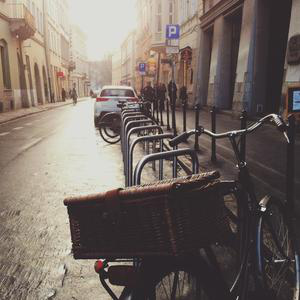

In [142]:
image